In [1]:
import numpy as np
import pandas as pd
import cv2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Rectangle

In [3]:
from opensfm import dataset,tracking
from opensfm import features as ft

In [4]:
from math import inf

In [5]:
from scipy.spatial import Delaunay,ConvexHull
from scipy.optimize import linprog

In [6]:
data = dataset.DataSet('./')
features=tracking.load_features(data,data.image_list)
matches=tracking.load_matches(data,data.image_list)

In [7]:
# data.image_list[11]

In [8]:
images=["images/"+image for image in data.image_list]
images=[cv2.imread(image) for image in images]

In [9]:
#Denormalisation
featuresCoorDen={}
for im in data.image_list:
    norCoord=features[0][im][:,0:2]
    height,width=data.image_size(im)
#     matrixToOriginal=np.array([[max(width,height),0,(width-1)/2],[0,max(width,height),(height-1)/2],[0,0,1]])
#     featuresCoorDen[im]=np.hstack((norCoord, np.ones((norCoord.shape[0], 1), dtype=norCoord.dtype)))@matrixToOriginal
    featuresCoorDen[im]=ft.denormalized_image_coordinates(features[0][im],width,height)

In [10]:
#bounding box of a circle
def getMinimumTemplate(image,row,col,nbKey,matches,disM):
    dis=0
    nb=0
    if nbKey==0:
        m=np.sum((matches-np.array([[row,col]]))**2,axis=1)<disM**2
        return disM,m
    while nb<nbKey:
        dis+=1
        m=np.sum((matches-np.array([[row,col]]))**2,axis=1)<dis**2
        nb=matches[m].shape[0]
    return dis,m

In [11]:
def returnWindow(image,d,r,c):
    hs,hf=c-d,c+d
    if hs<0:
        hs=0

    if hf>image.shape[0]-1:
        hf=image.shape[0]-1

    ws,wf=r-d,r+d
    if ws<0:
        ws=0

    if wf>image.shape[1]-1:
        wf=image.shape[1]-1

    g=image[hs:hf,ws:wf,:]
    
    r2,c2=r-ws,c-hs
    
    return g

In [12]:
def returnWindowRectangle(image,dR,dC,r,c):
    hs,hf=c-dC,c+dC
    if hs<0:
        hs=0

    if hf>image.shape[0]-1:
        hf=image.shape[0]-1

    ws,wf=r-dR,r+dR
    if ws<0:
        ws=0

    if wf>image.shape[1]-1:
        wf=image.shape[1]-1

    g=image[hs:hf,ws:wf,:]
    
    r2,c2=r-ws,c-hs
    return g

In [32]:
#need to deal with linear positionnement check det?
def getClosestKeyPoints(row,col,keyPoints,nbKey):
    a=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)
    return np.argsort(a)[0:nbKey]

#add max distance
def getClosestSurrondingPoints(row,col,keyPoints,nbKey):
    dis=1
    nb=0
    mask=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)<1
    while nb<nbKey :
        dis+=1
        mask=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)<dis**2
        nb=keyPoints[mask].shape[0]
    return mask

def findindingClosest3Points(row,col,keyPoints,triang,onlyThree=True):
    g=triang.simplices[triang.find_simplex(np.array([row,col]))]
    if np.any(g==(-1)):
        return -1
#     print(g.shape,tri.neighbors[g])
#     print(np.append(tri.neighbors[g],np.array([g]),axis=0).shape)
    print(triang.simplices[tri.neighbors[triang.find_simplex(np.array([row,col]))]].ravel())
    neighAll=np.append(triang.simplices[tri.neighbors[triang.find_simplex(np.array([row,col]))]].ravel(),g)
    print(neighAll)
#     neighAll=np.append(tri.neighbors[g].ravel(),g)
    neighAll=np.unique(neighAll)
#     neighAll=np.argsort(np.sum((keyPoints[neighAll]-np.array([[row,col]]))**2,axis=1))[0:6]
    print(g,neighAll)
#     return neighAll
    if onlyThree:
        return g
    return neighAll
 
# findindingClosest3Points(row,col,kp1,tri)
    

In [33]:
# check wether a point is inside the convex hull
# convex combination of points
def in_hull(keyPoints,row,col):
    dim=keyPoints.shape[0]
    A=keyPoints.T
    A=np.vstack((A,np.ones((1,dim))))
    x=np.zeros(dim)
    b=np.array([[row],[col],[1]])
    lp=linprog(x,A_eq=A,b_eq=b,bounds = (0, None))
    return lp.success
# in_hull(kp1,200,40)

In [34]:
#returns rectangle bounding box
#there isnt any need to check if its within the picture because it only takes into account min and max of points
#     only need topl and botR
#     topL,topR,botL,botR=(minR,minC),(maxR,minC),(minR,maxC),(maxR,maxC)
#     return topL,topR,botL,botR
def getBoundingBox(pts):
    [minR,minC]=np.min(pts,axis=0)
    [maxR,maxC]=np.max(pts,axis=0)  
    topL,botR=(int(minR),int(minC)),(int(maxR)+1,int(maxC)+1)
    return topL,botR

In [35]:
def fromBbToImage(image,topL,botR):
    return image[topL[1]:botR[1],topL[0]:botR[0],:]

In [36]:
#data
kp1=featuresCoorDen[data.image_list[0]][matches[(data.image_list[1],data.image_list[0])][:,1]]
kp2=featuresCoorDen[data.image_list[1]][matches[(data.image_list[1],data.image_list[0])][:,0]]

# kp1=np.unique(kp1,axis=0)
# kp2=np.unique(kp2,axis=0)

image1,image2=images[0],images[1]

kp1=np.append(kp1,np.array([[0,0],[0,image1.shape[0]-1],[image1.shape[1]-1,0],[image1.shape[1]-1,image1.shape[0]-1]]),axis=0)
kp2=np.append(kp2,np.array([[0,0],[0,image2.shape[0]-1],[image2.shape[1]-1,0],[image2.shape[1]-1,image2.shape[0]-1]]),axis=0)

# row,col=3919,3474
# row,col=3684,3028

##corner tree point upper down
# row,col=2383,3600

##corner tree point upper right
# row,col=2437,3568  

##corner tree point upper left
row,col=2280,3547  


##corner tree point down left
# row,col=2237,3582
scale=1

# mask=getClosestKeyPoints(row,col,kp1,3)
# mask=getClosestSurrondingPoints(row,col,kp1,3)


if not in_hull(kp1,row,col):
    raise Exception("point not inside the convex hull")
    
tri = Delaunay(kp1)    
tri2=Delaunay(kp2)   
mask=findindingClosest3Points(row,col,kp1,tri)

if mask.any()==-1:
    raise Exception("triangulation didnt find any simplex/try with another method")

kpP1=kp1[mask]
kpP2=kp2[mask]

#additionnal step
# l=np.argsort(np.sum((kpP1-np.array([[row,col]]))**2,axis=1))[0:min(6,kpP1.shape[0])]
# kpP1=kpP1[l]
# kpP2=kpP2[l]

print("r",kpP1)

# coordinates of the bounding boxes
tL1,br1=getBoundingBox(kpP1)
tL2,br2=getBoundingBox(kpP2)


#boxes -> images
box1,box2=fromBbToImage(image1,tL1,br1),fromBbToImage(image2,tL2,br2)

#choosing a window centered in the point that have dimensions smaller than the bounding box
kernelD=40
#new coordinates in the first box
r2,c2=row-tL1[0],col-tL1[1]
print(r2,c2)
# while r2-kernelD<0 or c2-kernelD<0 or r2+kernelD>=br1[0]-tL1[0] or c2+kernelD>=br1[1]-tL1[1] :
#     kernelD-=1

# temp=returnWindow(image1,kernelD,row,col)

# print(kernelD)

kernelDR=20
kernelDC=20
while r2-kernelDR<0 or r2+kernelDR>=br1[0]-tL1[0] :
    kernelDR-=1

while c2-kernelDC<0 or c2+kernelDC>=br1[1]-tL1[1] :
    kernelDC-=1

temp=returnWindowRectangle(image1,kernelDR,kernelDC,row,col)
print(kernelDR,kernelDC)

#coorelation template based matching test:
res=cv2.matchTemplate(box2,temp,cv2.TM_CCOEFF_NORMED)
print(box2.shape,res.shape)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
# closestKeyMask=getClosestKeyPoints(row,col,kp1,1)
# closestK1=kp1[closestKeyMask]
# closestK2=kp2[closestKeyMask]
# ciSearch=(closestK2-tL2-np.array([temp.shape[1]-1,temp.shape[0]-1])).astype(int)

# # print(ciSearch)
# radius=100
# fl=res[ciSearch[0,0]-radius:ciSearch[0,0]+radius,ciSearch[0,1]-radius:ciSearch[0,1]+radius]
# max_loc2=cv2.minMaxLoc(fl)[3]
# max_loc2=max_loc2[0]+ciSearch[0,0]-radius,+max_loc2[1]+ciSearch[0,1]-radius

# max_loc=max_loc2

centroidFoundB2=max_loc[0]+(temp.shape[1]*scale)/2,max_loc[1]+(temp.shape[0]*scale)/2
centroidFound=centroidFoundB2[0]+tL2[0],centroidFoundB2[1]+tL2[1]

print(centroidFound)

[ 95 108 137 256 222 137  95 222 171]
[ 95 108 137 256 222 137  95 222 171 222  95 137]
[222  95 137] [ 95 108 137 171 222 256]
r [[2170.83276367 3478.56616211]
 [2583.84106445 3425.04931641]
 [2391.29541016 3720.54833984]]
110 122
20 20
(147, 276, 3) (108, 237)
(2518.0, 3418.0)


<IPython.core.display.Javascript object>


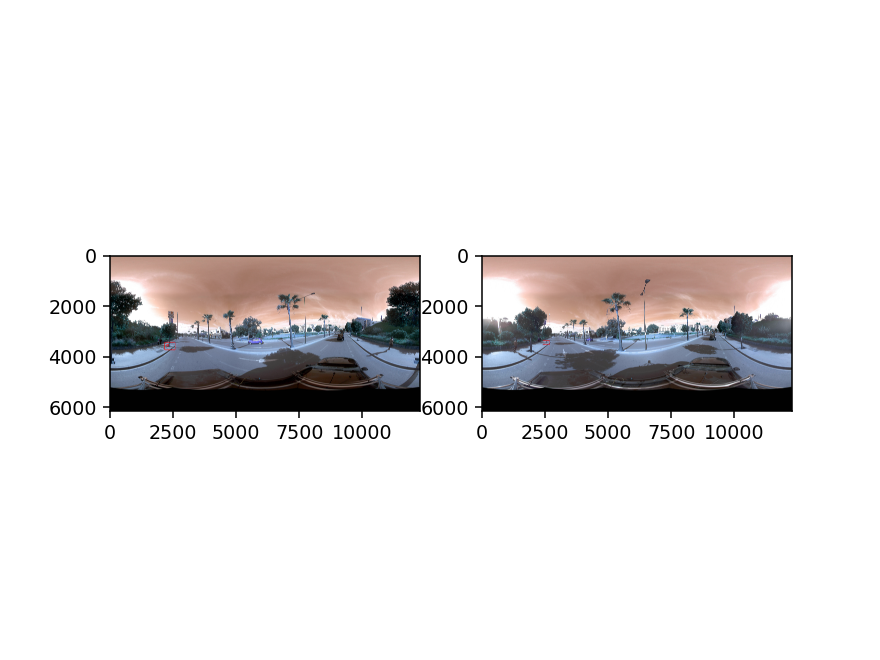

In [37]:
# showing of the bounding boxes in the context of the photo
cop1=image1.copy()
cop2=image2.copy()

cv2.rectangle(cop1,tL1,br1,(255,0,0),20)
cv2.rectangle(cop2,tL2,br2,(255,0,0),20)

%matplotlib notebook
fig,ax=plt.subplots(1,2)
ax[0].imshow(cop1)
for key in kpP1:
    ax[0].add_patch(Circle(key,10))
ax[0].add_patch(Circle((row,col),10,color='red'))
ax[1].imshow(cop2)
for key in kpP2:
    ax[1].add_patch(Circle(key,10))

<IPython.core.display.Javascript object>


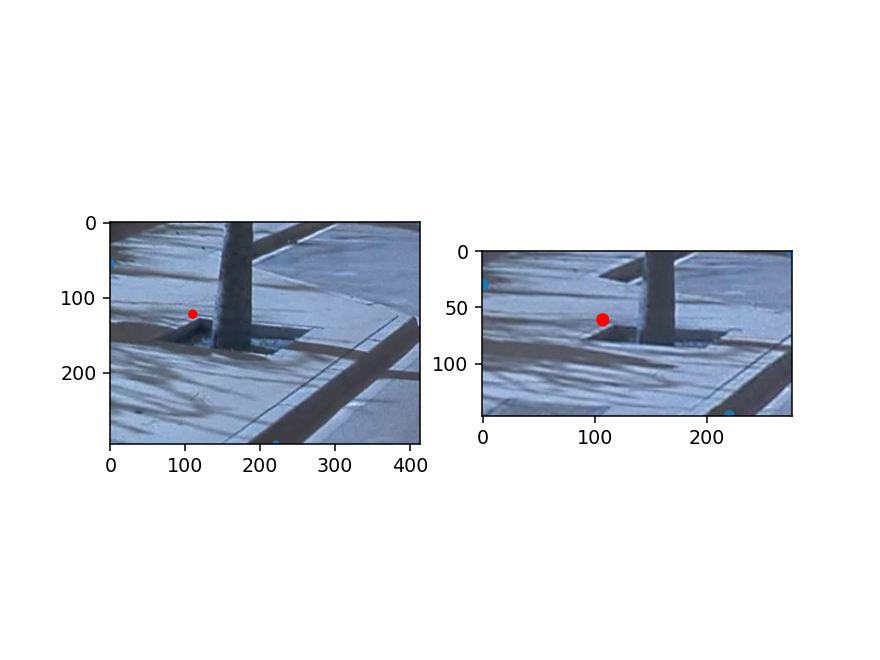

In [43]:
# showing of the patterns inside the bounding box:
bCop1=box1.copy()
bCop2=box2.copy()

# cv2.rectangle(bCop1,(r2-temp.shape[1]//2,c2-temp.shape[0]//2),(r2+temp.shape[1]//2,c2+temp.shape[0]//2),(255,0,0),1)
# cv2.rectangle(bCop2,max_loc,(max_loc[0]+temp.shape[1]*scale,max_loc[1]+temp.shape[0]*scale),(255,0,0),1)

%matplotlib notebook
fig,ax=plt.subplots(1,2)
ax[0].imshow(bCop1)
for key in kpP1:
    ax[0].add_patch(Circle(key-tL1))
ax[0].add_patch(Circle(np.array([row,col])-tL1,color='red'))
    
ax[1].imshow(bCop2)
for key in kpP2:
    ax[1].add_patch(Circle(key-tL2))
ax[1].add_patch(Circle((centroidFoundB2[0],centroidFoundB2[1]),color='red'))

<IPython.core.display.Javascript object>


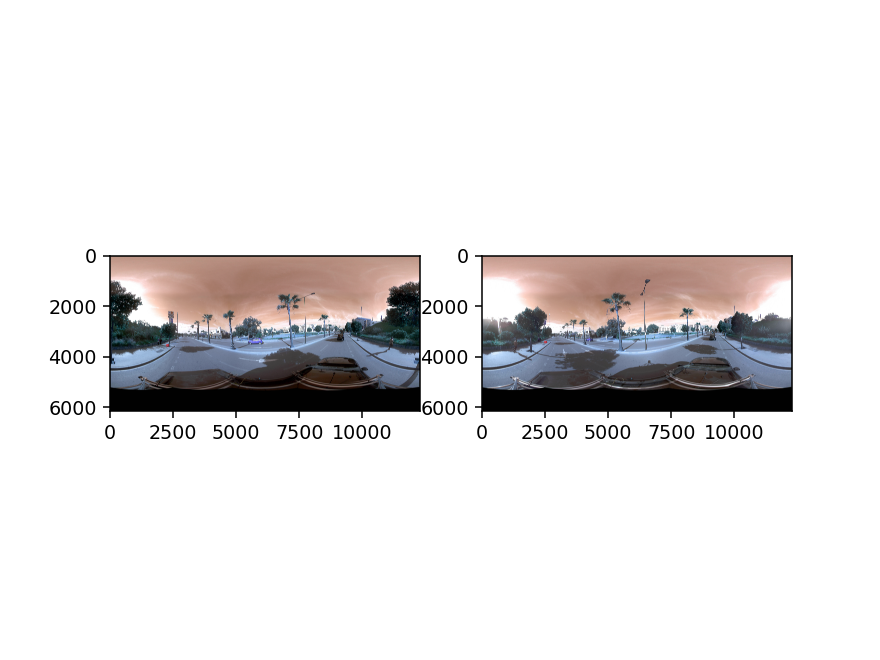

In [39]:
# showing result
cop1=image1.copy()
cop2=image2.copy()

cv2.rectangle(cop1,tL1,br1,4)
cv2.rectangle(cop2,tL2,br2,4)

%matplotlib notebook
fig,ax=plt.subplots(1,2)
ax[0].imshow(cop1)
for key in kpP1:
    ax[0].add_patch(Circle(key,10))
ax[0].add_patch(Circle((row,col),10,color='red'))
ax[1].imshow(cop2)
for key in kpP2:
    ax[1].add_patch(Circle(key,10))
ax[1].add_patch(Circle(centroidFound,10,color='red'))

In [40]:
###Delauney Triangulation

<IPython.core.display.Javascript object>


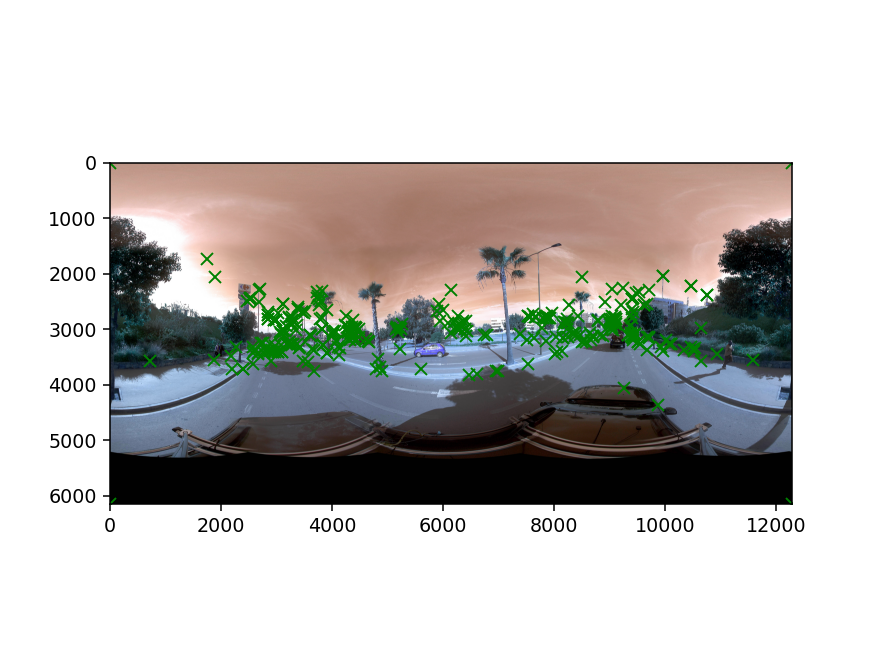

In [41]:
%matplotlib notebook
fig,ax=plt.subplots(1)
# ax.triplot(kp2[:,0],kp2[:,1],tri2.simplices)
ax.imshow(image1)
ax.plot(kp1[:,0],kp1[:,1], 'gx')
# ax.plot(500,20,'x')

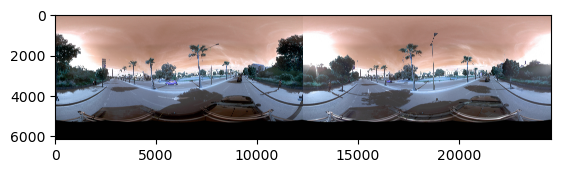

In [23]:
%matplotlib inline
image=cv2.hconcat([image1,image2])
plt.imshow(image)

In [24]:
kp1[tri.simplices[tri.find_simplex(np.array([row,col]))]]

array([[2170.83276367, 3478.56616211],
       [2583.84106445, 3425.04931641],
       [2391.29541016, 3720.54833984]])

In [25]:
#boundary set
# boundary = set()
# for i in range(len(tri.neighbors)):
#     for k in range(3):
#         if (tri.neighbors[i][k] == -1):
#             nk1,nk2 = (k+1)%3, (k+2)%3 
#             boundary.add(tri.simplices[i][nk1])
#             boundary.add(tri.simplices[i][nk2])

<IPython.core.display.Javascript object>


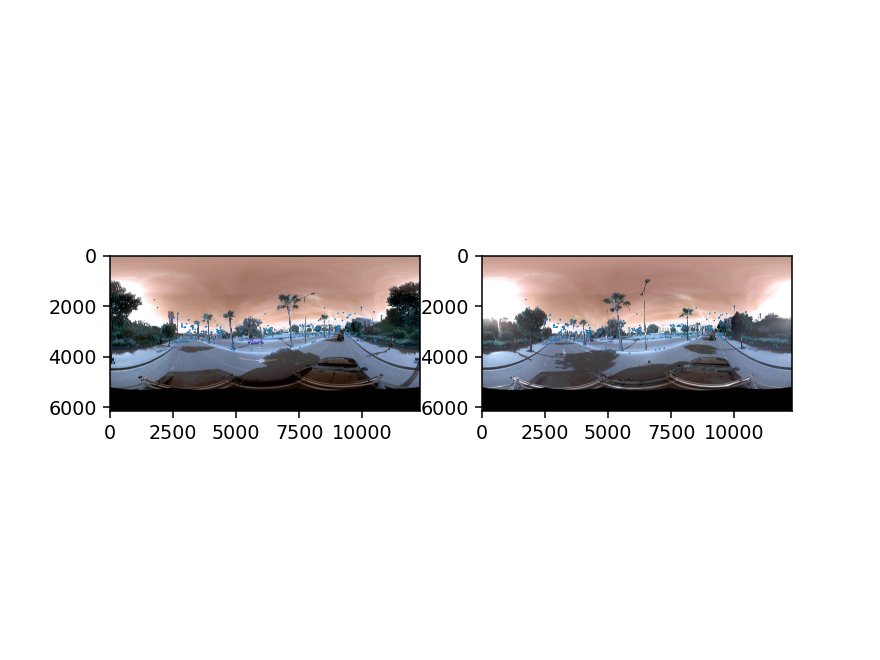

In [26]:
%matplotlib notebook
fig,ax=plt.subplots(1,2)
ax[0].imshow(image1)
for key in kp1:
    ax[0].add_patch(Circle(key,30))
ax[1].imshow(image2)
for key in kp2:
    ax[1].add_patch(Circle(key,30))

In [27]:
#1 image 2437,3568

In [28]:
#2 image centroidFound

In [29]:
#   -7.643351289219483 33.53795330870294 | (2603.0, 3423.0)

In [31]:
-7.64361040473787943,3.53779629052377

(-7.6436104047378794, 3.53779629052377)

In [ ]:
# fig,ax=plt.subplots(1,4)
# ax[0].imshow(image1)
# ax[0].set_title("image")
# ax[1].imshow(image2)
# ax[2].triplot(kp1[:,0],kp1[:,1],tri.simplices)
# ax[2].imshow(image1)
# ax[2].plot(kp1[:,0],kp1[:,1], 'o')
# ax[3].triplot(kp2[:,0],kp2[:,1],tri.simplices)
# ax[3].imshow(image2)
# ax[3].plot(kp2[:,0],kp2[:,1], 'o')